# ASSIGNMENT #4 - SURFACE WEATHER DATA #
Due: 31 March 2024 @ 11:59p

Purpose:\
The purpose of this assignment is to continue to strengthen skills with reading in data by reading in surface observations from a text file.  The data is then plotted on a map to begin to familiarize with plotting weather data on maps.

Overview:\
In this assignment you will read in surface weather data, quality control that data, and plot that data .


| | UPDATE TO YOUR INFORMATION | 
| :- | :- |
| Created By | Jared W. Marquis |
| Creation Date | 18 January 2024 |
| Course | ATSC 270 - Computer Concepts in Meteorology |

In [1]:
### UPDATE TO YOUR INFORMATION ###
#information allowing anyone with the code to print the author and contact information
__author__    = "Kellie Thrower"
__contact__   = "kellie.thrower@und.edu"

### IMPORT REQUIRED LIBRARIES ###

In [2]:
import numpy as np

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import current_weather, sky_cover, StationPlot, simple_layout
from metpy.io import metar

import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

### OPEN OBSERVATIONS TEXT FILE ###
Open the text file containing the surface observations using the metpy metar reader -> metar.parse_metar_file(filename).

In [3]:
filename = "metar_20240112_2100.txt"
data = metar.parse_metar_file(filename, year=2024, month=1)

#temp = air_temperature
data['air_temperature'] = (data['air_temperature']*9/5) + 32
data['dew_point_temperature'] = (data.dew_point_temperature*9/5) + 32
print(data.loc['KCLT'])

           station_id  latitude  longitude  elevation           date_time  \
station_id                                                                  
KCLT             KCLT     35.22     -80.95      220.0 2024-01-12 20:52:00   
KCLT             KCLT     35.22     -80.95      220.0 2024-01-12 21:07:00   

            wind_direction  wind_speed  wind_gust  visibility current_wx1  \
station_id                                                                  
KCLT                 100.0         8.0       18.0    4023.360          RA   
KCLT                 120.0         6.0        NaN    4828.032         -RA   

            ... air_temperature dew_point_temperature altimeter  \
station_id  ...                                                   
KCLT        ...            51.8                  46.4     29.62   
KCLT        ...            51.8                  46.4     29.64   

            current_wx1_symbol current_wx2_symbol  current_wx3_symbol  \
station_id                              

### REMOVE DATA THAT IS INCOMPLETE ###
Just remove data with no wind direction or wind speed.

In [4]:
data = data.dropna(how='any', subset=['wind_direction','wind_speed'])

print(data)

           station_id  latitude   longitude  elevation           date_time  \
station_id                                                                   
KGYH             KGYH     34.75  -82.380000      292.0 2024-01-12 20:47:00   
KMFV             KMFV     37.63  -75.770000       15.0 2024-01-12 20:55:00   
KPLD             KPLD     40.45  -84.983333      282.0 2024-01-12 20:55:00   
KIKT             KIKT     28.52  -88.280000       25.0 2024-01-12 20:50:00   
PAKU             PAKU     70.31 -149.580000        2.0 2024-01-12 20:45:00   
...               ...       ...         ...        ...                 ...   
OIYY             OIYY     31.90   54.280000     1236.0 2024-01-12 21:50:00   
ORNI             ORNI     31.98   44.400000       53.0 2024-01-14 21:00:00   
NFTV             NFTV    -18.57 -173.970000       71.0 2024-01-12 21:00:00   
NFTL             NFTL    -19.78 -174.330000        3.0 2024-01-12 21:00:00   
NFTF             NFTF    -21.23 -175.150000       38.0 2024-01-1

### PLOT MAP ###

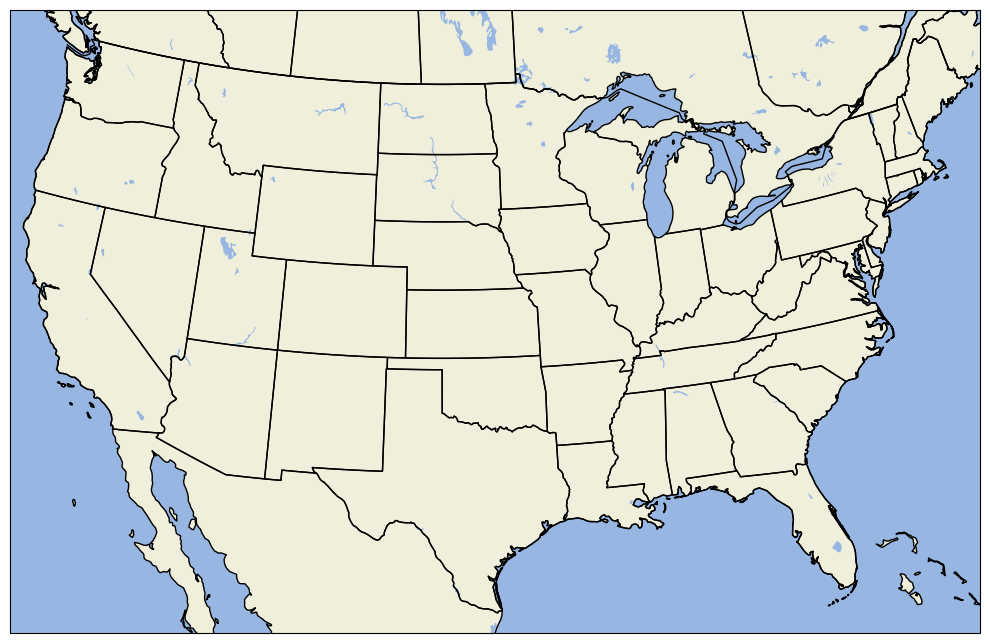

In [5]:
#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#save the map as empty_map.png
plt.savefig('emptymap.png')

### PLOT A NEW MAP BUT ADD SURFACE OBS LOCATIONS ###

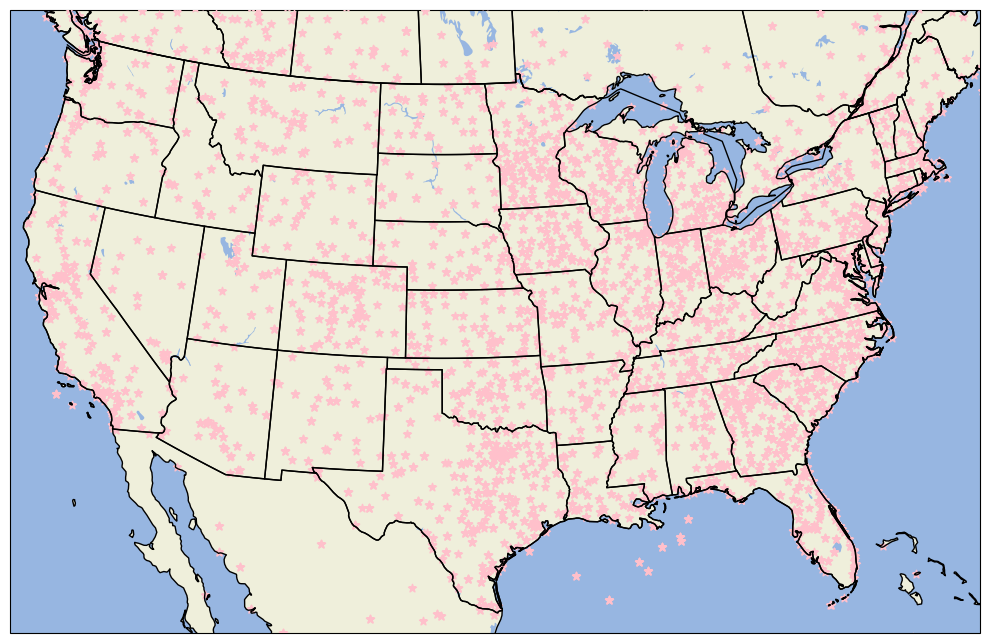

In [6]:
#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.OCEAN,zorder=0)
ax.add_feature(cfeature.LAKES,zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=10)
ax.add_feature(cfeature.STATES,zorder=10)
ax.add_feature(cfeature.BORDERS,zorder=10)

ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#plot surface obs using scatter plot
ax.scatter(data.longitude,data.latitude,transform=ccrs.PlateCarree(), color = 'pink', marker = '*',zorder=9)

fig.tight_layout()
#save the map as obs_locations.png
plt.savefig('obs_locations.png',bbox_inches='tight')

### WAY TOO MANY OBS ###
There are way too many obs for us to be able to actually see what the weather is.  We need to "thin" the obs in areas of very high densiy.

We'll do this using the *metpy.calc.reduce_point_density* function.

Find a density that works well for you.  The units for density are meters, so 100000 is roughly one observation/100km.


In [7]:
#first convert the lat/lon to map projection coordinates
locs = proj.transform_points(ccrs.PlateCarree(),data['longitude'].values,data['latitude'].values)

#now thin the data
data_thinned = data[mpcalc.reduce_point_density(locs,190*units('km'))]

### SAVE OBS LOCATIONS ON NEW MAP ###

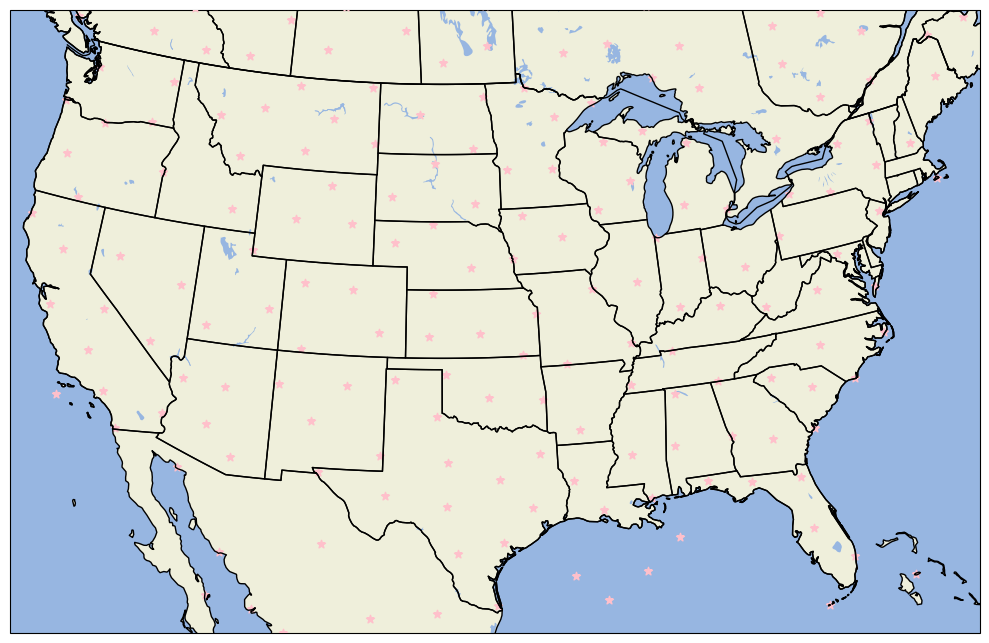

In [8]:
#save the map as obs_locations_thinned.png
#first convert the lat/lon to map projection coordinates

#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.OCEAN,zorder=0)
ax.add_feature(cfeature.LAKES,zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=10)
ax.add_feature(cfeature.STATES,zorder=10)
ax.add_feature(cfeature.BORDERS,zorder=10)

ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#plot surface obs using scatter plot
ax.scatter(data_thinned.longitude,data_thinned.latitude,transform=ccrs.PlateCarree(), color = 'pink', marker = '*',zorder=9)

fig.tight_layout()
#save the map as obs_locations.png
plt.savefig('obs_locations.png',bbox_inches='tight')


### ONCE YOU'RE HAPPY WITH THE DENSITY, PLOT SURFACE STATIONS ###
For this use the *StationPlot* object in metpy -> https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html

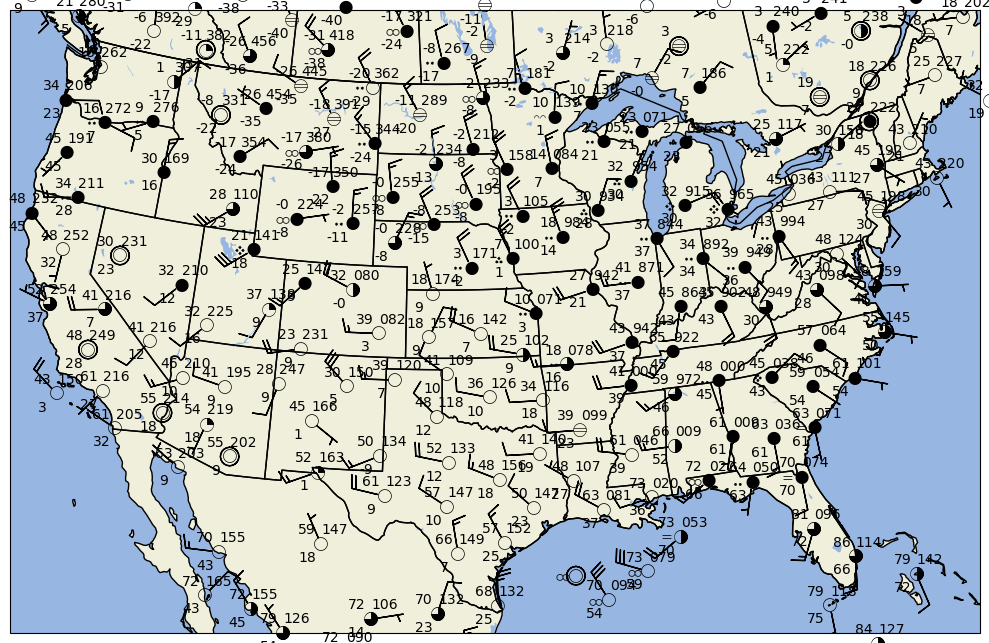

In [9]:
#save the map as obs_locations_thinned.png
#first convert the lat/lon to map projection coordinates

#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.OCEAN,zorder=0)
ax.add_feature(cfeature.LAKES,zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=10)
ax.add_feature(cfeature.STATES,zorder=10)
ax.add_feature(cfeature.BORDERS,zorder=10)

ax.set_extent((-120, -75, 23, 50))

stationplots = StationPlot(ax, data_thinned['longitude'], data_thinned['latitude'], transform = ccrs.PlateCarree(),)
simple_layout.plot(stationplots,data_thinned)

fig.tight_layout() 

#save the map as simple_surface_obs.png
plt.savefig('simple_surface_obs.png')

### PLOT NORTHERN PLAINS ###
Now we are going to focus on the Northern Great Plains and make a custom layout.<br>
We will set the extent to 150W to 90W and 40N to 50N.<br>
We will also need to re-thin the data since we will be zoomed in and can see more obs.<br><br>
Data that will be plotted:<br>
 - Temperature in the top left
 - Dewpoint in bottom left
 - Pressure in top right
 - Station ID in bottom right
 - Current weather on left
 - Visibility in miles on far left
 - Wind barb in black
 - Wind gust barb in red

In [10]:
data_thinned = data[mpcalc.reduce_point_density(locs,90*units('km'))]


In [11]:
#create wind gust vectors
u = data_thinned.eastward_wind.values * units('knots')
v = data_thinned.northward_wind.values * units('knots')
gust = data_thinned.wind_gust.values * units('knots')
wdir = mpcalc.wind_direction(u,v)

ug, vg = mpcalc.wind_components(gust,wdir)
#mpcalc.wind_direction(data_thinned).eastward_wind,data_thinned.northward_wind))
#do this by multiplying each component by the ratio of gust to speed
for i in ug:
    print(i)

nan knot
nan knot
nan knot
27.712812921102028 knot
nan knot
24.6201938253052 knot
20.0 knot
25.371700761219525 knot
34.0 knot
nan knot
23.0 knot
10.500000000000002 knot
18.711347307231954 knot
-6.42498257367642 knot
3.2993153756716773 knot
-13.155696691002717 knot
nan knot
-10.284601754984632 knot
nan knot
-26.311393382005434 knot
-9.918584156444398 knot
-10.284601754984632 knot
nan knot
nan knot
nan knot
4.341204441673262 knot
20.673237657289985 knot
22.0 knot
18.0 knot
nan knot
nan knot
9.641814145298088 knot
27.574617084341824 knot
21.0 knot
nan knot
-16.741731801207536 knot
nan knot
nan knot
nan knot
-14.554844419260583 knot
nan knot
nan knot
-16.06969024216348 knot
nan knot
-12.499999999999998 knot
-17.499999999999996 knot
-12.21296458404425 knot
-19.15111107797445 knot
-5.814342436536371 knot
nan knot
-13.788799976141604 knot
-13.788799976141604 knot
-15.974774553360444 knot
38.40750236747612 knot
nan knot
nan knot
-23.78314155840196 knot
nan knot
-17.619022191736494 knot
nan kno

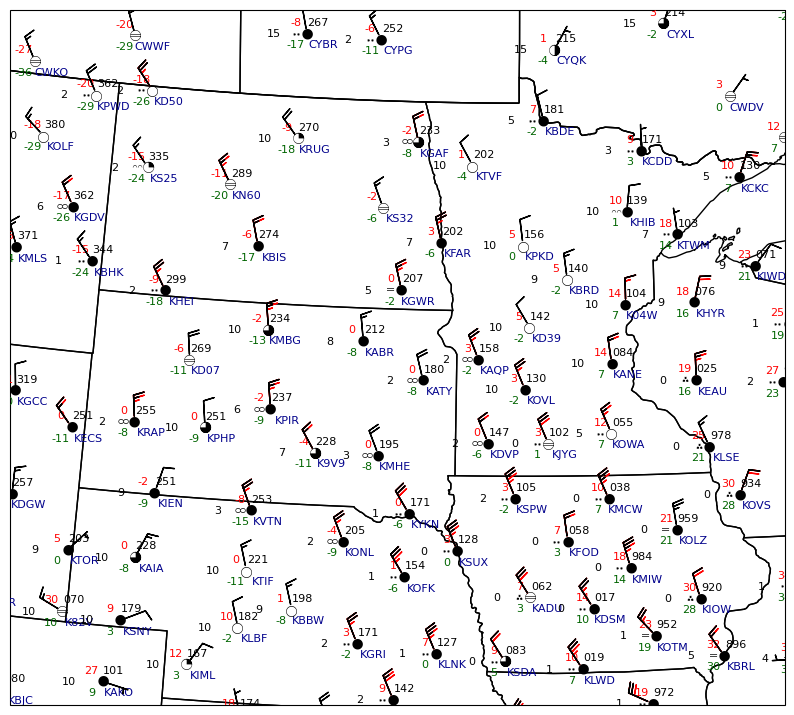

In [12]:
#map projection
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35)

#create figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the Northern Plains
ax.set_extent((-105, -90, 40, 50))

#create stationplot (will actually need to create 2 to handle wind gusts)
stationplots = StationPlot(ax, data_thinned['longitude'], data_thinned['latitude'], transform = ccrs.PlateCarree(),clip_on='True',fontsize=8)
stationplots_barbs = StationPlot(ax, data_thinned['longitude'], data_thinned['latitude'], transform = ccrs.PlateCarree(),clip_on='True',fontsize=8)
#simple_layout.plot(stationplots,data_thinned)
#temperature in red
stationplots.plot_parameter((-1,1), data_thinned['air_temperature'].values, color='red')
#dewpoint in dark green
stationplots.plot_parameter((-1,-1), data_thinned['dew_point_temperature'].values, color='darkgreen')
#pressure (need to format to be the final 3 digits)
stationplots.plot_parameter((1,1), data_thinned['air_pressure_at_sea_level'].values, color='black', formatter=lambda p: format(10*p, '.0f')[-3:])
#station ID in dark blue
stationplots.plot_text((1.5,-1), data_thinned['station_id'].values, color='darkblue')
#visibility in black (need to convert from meters to miles)
stationplots.plot_parameter((-3,0), data_thinned['visibility'].values*units('meters').to('miles'), color = 'black')
#wind gust in red
stationplots_barbs.plot_barb(ug, vg, color = 'r', zorder=9)
#wind in black
stationplots.plot_barb(data_thinned['eastward_wind'].values, data_thinned['northward_wind'].values, zorder=10)
#cloud cover
stationplots.plot_symbol('C', data_thinned['cloud_coverage'].values, sky_cover)
#current weather
stationplots.plot_symbol('W', data_thinned['current_wx1_symbol'].values, current_weather)
#save the map as surface_obs.png
plt.savefig('surface_obs.png')